# Electricity Demand Forecasting

## Model Evaluation

For the final model evaluation we choose the best prophet model and evaluate
the model with out of sample data.  Because some of the exogeneous data is
weather related and we would not know the exact weather prior to the day we
will add some random variation to the data before using it for input to the
prediction portion of the model.

## <table id='Table_Of_Contents'>Table Of Contents</table>

1. [Import Modules](#import)<br>
2. [Data Import](#read_data)<br>
    2A. [Data Aggregation](#data_agg)<br>
    2B. [Data Reconfiguration](#reconfig_data)<br>
3. [Create Future Exogenous Data](#simulate_exog)<br>
4. [Model and Forecast](#forecast)




----

## <a id='import'> 1. Import Modules</a>

----

In [1]:
import os
import sys

import numpy as np
import pandas as pd

import re

import json
import datetime


from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

import pickle
import warnings

from dateutil import parser
import dateutil

from fbprophet import Prophet

import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.statespace.mlemodel

import sys

sys.path.append('../src')
from EF_tools import agg_daily, agg_weekly

----

## <a id='read_data'>2. Data Import </a>

----

In [2]:
# Read in the training and test data sets
X_train = pd.read_csv('../data/big_demand_temp_train.csv', index_col=0)
X_val = pd.read_csv('../data/big_demand_temp_validation.csv', index_col=0)

X_train.index = pd.DatetimeIndex(X_train.index)
X_val.index = pd.DatetimeIndex(X_val.index)

In [3]:
X_train.tail()

,demand,Los Angeles,San Diego,San Jose,San Francisco,Sacramento,Fresno,CA_pop,date,Mon,Tue,Wed,Thur,Fri,Sat,Sun,DOW
2019-03-31 19:00:00,21782.0,78.14,76.39,66.93,60.40,61.51,63.82,14173349.0,2019-03-31,0,0,0,0,0,0,1,6
2019-03-31 20:00:00,21851.0,81.11,79.76,69.05,62.56,64.24,67.47,14173349.0,2019-03-31,0,0,0,0,0,0,1,6
2019-03-31 21:00:00,21960.0,81.93,78.97,72.43,66.71,67.20,70.13,14173349.0,2019-03-31,0,0,0,0,0,0,1,6
2019-03-31 22:00:00,22742.0,82.54,77.68,74.24,67.60,70.43,72.52,14173349.0,2019-03-31,0,0,0,0,0,0,1,6
2019-03-31 23:00:00,23027.0,82.41,76.83,74.12,68.53,72.14,74.41,14173349.0,2019-03-31,0,0,0,0,0,0,1,6


In [4]:
X_val.head()

,demand,Los Angeles,San Diego,San Jose,San Francisco,Sacramento,Fresno,CA_pop,date,Mon,Tue,Wed,Thur,Fri,Sat,Sun,DOW
2019-04-01 00:00:00,24233.0,81.03,76.26,73.87,65.30,73.42,75.23,14173349.0,2019-04-01,1,0,0,0,0,0,0,0
2019-04-01 01:00:00,25377.0,77.71,73.92,71.25,62.63,73.58,74.98,14173349.0,2019-04-01,1,0,0,0,0,0,0,0
2019-04-01 02:00:00,25263.0,74.85,71.90,68.08,60.05,73.29,73.82,14173349.0,2019-04-01,1,0,0,0,0,0,0,0
2019-04-01 03:00:00,26855.0,71.74,70.20,64.87,58.02,64.46,71.32,14173349.0,2019-04-01,1,0,0,0,0,0,0,0
2019-04-01 04:00:00,26907.0,70.26,69.32,61.56,57.41,67.34,67.98,14173349.0,2019-04-01,1,0,0,0,0,0,0,0


----

### <a id='data_agg'> 2.A Data Aggregation </a>

----

In [5]:
# Aggregate the validation and training data for a daily time series
X_val_daily = agg_daily(X_val)
X_train_daily = agg_daily(X_train)


In [6]:
X_train_daily.tail()

,day_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW
2019-03-27,629377,1.41733e+07,72.07,66.64,67.46,61.6,65.87,72.72,2
2019-03-28,639380,1.41733e+07,67.59,66.66,64.57,61.27,62.33,68.11,3
2019-03-29,636137,1.41733e+07,70.69,66.45,63.14,58.67,61.7,68.67,4
2019-03-30,616083,1.41733e+07,79.99,69.88,66.95,62.73,67.95,69.09,5
2019-03-31,578308,1.41733e+07,82.54,79.76,74.24,68.53,72.14,74.41,6


In [7]:
X_val_daily.head()

,day_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW
2019-04-01,626489,1.41733e+07,81.71,76.26,73.87,65.3,73.58,77.52,0
2019-04-02,669576,1.41733e+07,78.29,71.37,64.76,60.96,65.02,77.62,1
2019-04-03,665924,1.41733e+07,67.45,64.96,63.3,57.93,62.98,70.45,2
2019-04-04,665258,1.41733e+07,66.69,65.34,62.77,60.93,64.1,70.27,3
2019-04-05,637302,1.41733e+07,66.07,64.94,64.02,60.99,63.16,67.1,4


----

### <a id='reconfig_data'> 2B. Data Reconfiguration </a>

----

In [8]:
# Create the y column for the prophet model
X_train_daily.rename({'day_demand' : 'y'}, axis=1, inplace=True)

# Create the date series column for the prophet model
X_train_daily['ds'] = X_train_daily.index
X_train_daily.index = pd.DatetimeIndex(X_train_daily.index)

In [9]:
# Create the y column for the prophet model
X_val_daily.rename({'day_demand' : 'y'}, axis=1, inplace=True)

# Create the date series column for the prophet model
X_val_daily['ds'] = X_val_daily.index
X_val_daily.index = pd.DatetimeIndex(X_val_daily.index)

In [10]:
# Combine the two dataframes
elec_df = X_train_daily.append(X_val_daily)

# Make sure the columns are the correct data type
retype_cols = elec_df.columns[1:-1]
temp_df = elec_df[retype_cols].astype(float)
elec_df[retype_cols] = temp_df

# Make sure the index is a datetime object
elec_df.index = pd.DatetimeIndex(elec_df.index)
elec_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1714 entries, 2015-07-01 to 2020-03-09
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   y         1714 non-null   object 
 1   CA_pop    1714 non-null   float64
 2   la_high   1714 non-null   float64
 3   sd_high   1714 non-null   float64
 4   sj_high   1714 non-null   float64
 5   sf_high   1714 non-null   float64
 6   sac_high  1714 non-null   float64
 7   f_high    1714 non-null   float64
 8   DOW       1714 non-null   float64
 9   ds        1714 non-null   object 
dtypes: float64(8), object(2)
memory usage: 147.3+ KB


----

## <a id='simulate_exog'> 3. Create Future Exogenous Data </a>

----

For the final demand prediction we need to provide temperature data.  Long term forecasts
are unreliable so I will use the observations in the current data to calculate a weekly
average for each city and use that for the future forecasted temperature.<br>
<br>

In [11]:
elec_df['week_num'] = [x.isocalendar()[1] for x in elec_df.index]
week_temps_df = elec_df.groupby('week_num').mean()

In [12]:
# Make a date time index for dates starting at the end of the dataframe
start_date = elec_df.index[-1]
dti = pd.date_range(start_date, periods=365, freq='D')

In [13]:
future_df = pd.DataFrame(index=dti, columns=elec_df.columns[1:-1])
for col in future_df.columns[1:-1] :
    future_df[col] = [week_temps_df.loc[x.isocalendar()[1], col] for x in future_df.index]
    
future_df['CA_pop'] = [elec_df['CA_pop'].values[-1]] * future_df.shape[0]

future_df.index = pd.DatetimeIndex(future_df.index)
future_df['ds'] = future_df.index
future_df.head()

,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW,ds
2020-03-09,14261874.0,73.695862,67.813793,68.74,64.437586,68.658276,71.68069,2.896552,2020-03-09
2020-03-10,14261874.0,73.695862,67.813793,68.74,64.437586,68.658276,71.68069,2.896552,2020-03-10
2020-03-11,14261874.0,73.695862,67.813793,68.74,64.437586,68.658276,71.68069,2.896552,2020-03-11
2020-03-12,14261874.0,73.695862,67.813793,68.74,64.437586,68.658276,71.68069,2.896552,2020-03-12
2020-03-13,14261874.0,73.695862,67.813793,68.74,64.437586,68.658276,71.68069,2.896552,2020-03-13


----

## <a id='forecast'> 4. Model And Forecast </a>

----

In [14]:
# Create a model instance with weekly and yearly seasonality
m = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)

# Add the exogenous regressors
m.add_regressor('la_high')
m.add_regressor('sd_high')
m.add_regressor('f_high')
m.add_regressor('sj_high')
m.add_regressor('sf_high')
m.add_regressor('sac_high')
m.add_regressor('CA_pop')

# Fit the model to the training data
model = m.fit(elec_df)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [15]:
# Create a forecast for the simulated future data
forecast = m.predict(future_df)
forecast.index = pd.DatetimeIndex(forecast['ds'])

/home/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



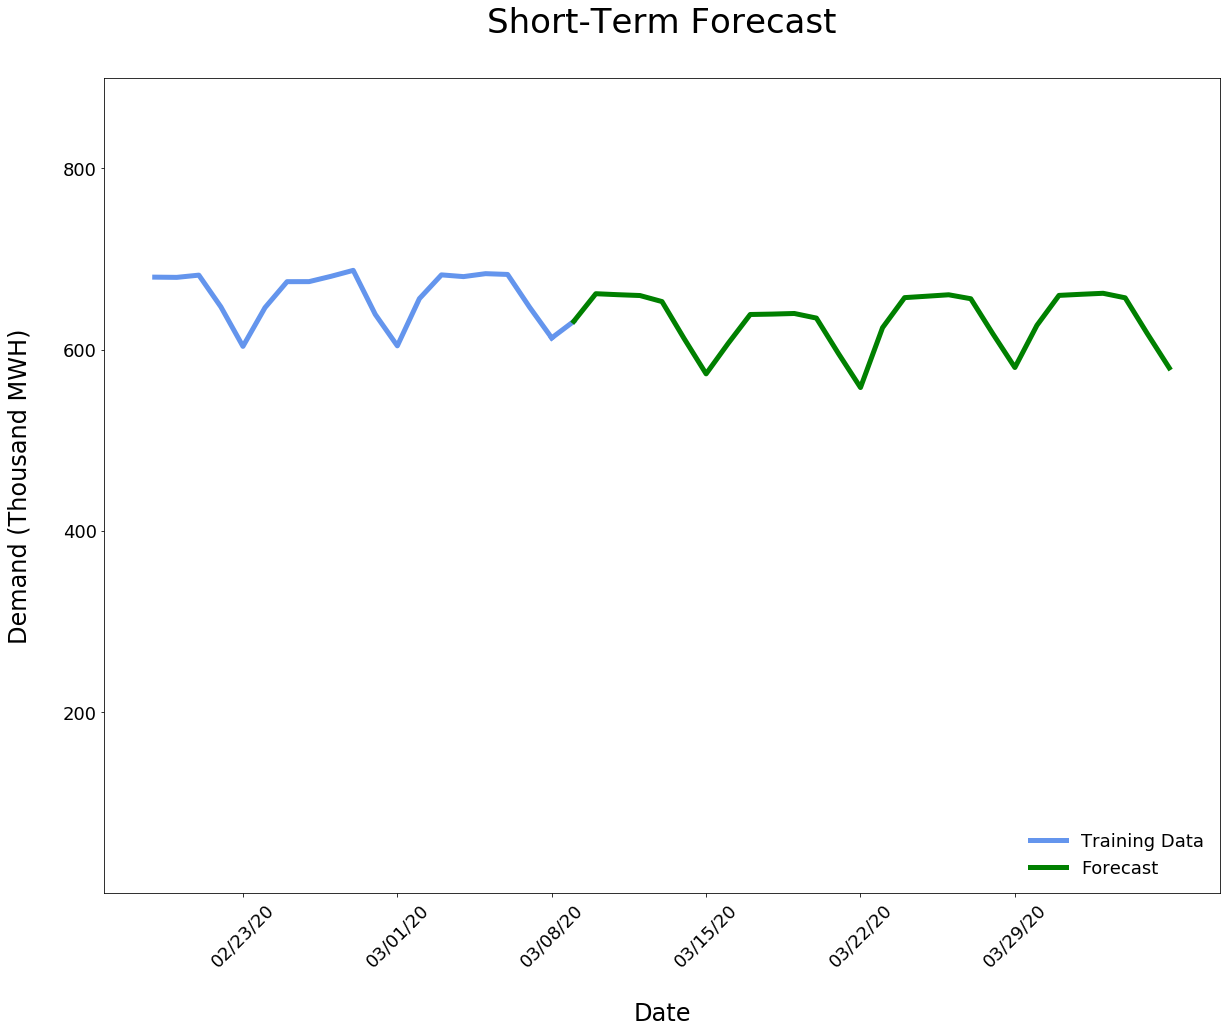

In [16]:
# Plot the Forecast and training data
fig = plt.figure(figsize=[20, 15])
fig.patch.set_alpha(0.0)
fig.patch.set_facecolor(None)

SMALL_SIZE = 18
MEDIUM_SIZE = 24
BIGGER_SIZE = 30

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

xticks = pd.date_range('2-20-20', periods=6, freq='W')
xticks = [x.date() for x in xticks]
xlabels = [x.strftime('%x') for x in xticks]
plt.xticks(xticks, xlabels, rotation=45)
plt.yticks([200000, 400000, 600000, 800000], ['200', '400', '600', '800'])

ax = fig.add_subplot(1,1,1)
ax.patch.set_visible(False)
ax.set_alpha(0.0)

plt.plot(facecolor=('#000000'), alpha=0.0)

plt.ylim(0, 900000)


plt.title('Short-Term Forecast\n', fontsize=34)
plt.xlabel('\nDate')
plt.ylabel('Demand (Thousand MWH)\n')
plt.legend(loc='lower right')

plt.plot(elec_df.index[-20:-1], elec_df['y'].values[-20:-1], \
    c='cornflowerblue', label='Training Data', linewidth=5)
plt.plot([elec_df.index[-2], forecast.index[0]], [elec_df['y'].values[-2],forecast['yhat'].values[0]], \
    c='cornflowerblue', linewidth=5)
plt.plot(forecast.index[:28], forecast['yhat'].values[:28], c='green', label='Forecast', linewidth=5)

leg = plt.legend(loc='lower right', facecolor=None)
leg.get_frame().set_alpha(0.0)

plt.savefig('daily_demand_forecast_final.png', Transparent=True)

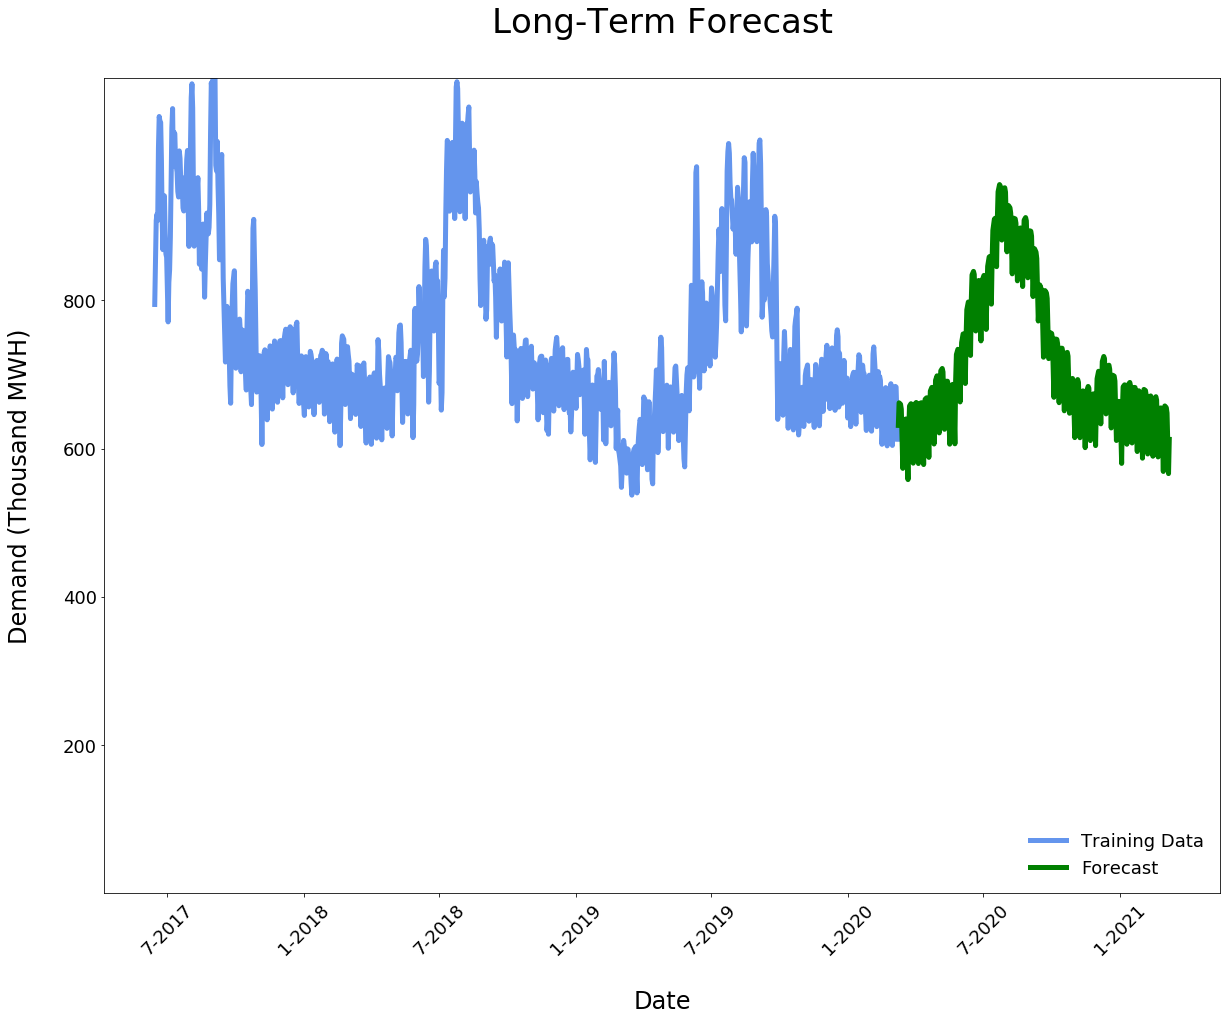

In [17]:
# Plot the forecast and training data on a larger scale
fig = plt.figure(figsize=[20, 15])
fig.patch.set_alpha(0.0)
fig.patch.set_facecolor(None)

ax = fig.add_subplot(1,1,1)
ax.patch.set_visible(False)
ax.set_alpha(0.0)

plt.plot(facecolor=('#000000'), alpha=0.0)

plt.ylim(0, 1100000)


SMALL_SIZE = 18
MEDIUM_SIZE = 24
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

xticks = pd.date_range(elec_df.index[-1000], periods=15, freq='Q')
xticks = [x.date()+datetime.timedelta(days=1) for x in xticks[::2]]
xlabels = ['%d-%d' % (x.month, x.year) for x in xticks]
plt.xticks(xticks, xlabels, rotation=45)
plt.yticks([200000, 400000, 600000, 800000], ['200', '400', '600', '800'])

plt.title('Long-Term Forecast\n', fontsize='34')
plt.xlabel('\nDate')
plt.ylabel('Demand (Thousand MWH)\n')
plt.legend(loc='lower right')

plt.plot(elec_df.index[-1000:-1], elec_df['y'].values[-1000:-1], \
    c='cornflowerblue', label='Training Data', linewidth=5)
plt.plot([elec_df.index[-2], forecast.index[0]], [elec_df['y'].values[-2],forecast['yhat'].values[0]], \
    c='cornflowerblue', linewidth=5)
plt.plot(forecast.index, forecast['yhat'].values, c='green', label='Forecast', linewidth=5)


leg = plt.legend(loc='lower right', facecolor=None)
leg.get_frame().set_alpha(0.0)

plt.savefig('daily_demand_forecast_final_long.png', Transparent=True)